## Instructions

This assignment is to use Kalman filter to implement the pair trading strategy of S&P 500 ETF and the Dow Jones Industrial ETF.

Please read the document (*Kalman filtering case study.pdf*) in Resources/Session 5 folder which discusses the Pair Trading strategy and answer the following questions.

(a). Derive the beta update equation (Kalman filter) for the pair trading strategy of the two ETFs ( which is the same format with the last equation on page 72).

(b). Code up the pair trading strategy and compare rolling regression vs Kalman filtering.

The data and instruction are in the attachments. Good luck (ง •̀_•́)ง ！

### 1. Data Processing

#### 1. Standard Settings

In [1]:
# standard magic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

# disable warnings
import warnings
warnings.filterwarnings('ignore')

#### 2. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from statsmodels.regression.rolling import RollingOLS
from statsmodels.formula.api import ols

#### 3. Fix the pseudorandom number generator

In [3]:
np.random.seed(17)

#### 4. Load Data & Drop Missing Values

In [4]:
# Step 1: Define a function processing the data
def process_data(lst):
    """ 
    input: lst
    output: dataset
    function: take the name of each dataset (excluding '.csv') in 'lst', and convert it into one pandas.DataFrame
    dataset called 'dataset' which can be directly used in our later models
    """
    ## Initialize a given list "data" to obtain all of the wanted data to combine later
    data = []
    
    ## Let 'data' dataset obtain the dataset for each 'df' in lst (Note: Here I attached the file directly to the
    ## directory where "spy.csv" and "djia.csv" are in)
    for df in lst:
        ticker_df = pd.read_csv(df + '.csv')
        
        ### Convert the "Date" column into the index for 'ticker_df'
        ticker_df = ticker_df.set_index(ticker_df['Date'])[['PX_LAST']]
        
        ### Rename the names of 'ticker_df' columns to combine later
        ticker_df = ticker_df.rename(columns = {'PX_LAST': df})
        
        ### Append the updated 'ticker_df'
        data.append(ticker_df)
        
    ## Generate the final pandas DataFrame dataset we want
    dataset = pd.concat(data, axis = 1).dropna()
    
    return dataset

Note that the function `process_data` only applies a particular data structure (i.e., pandas.DataFrame()) with a particular set of names of it as a given input (such as "Date" and "PX_LAST" in the given input). If any of these rules violate, then simply change part of codes or the data to the one which can be call by the function directly.

In [5]:
# Step 2: Get our wanted dataset & Take a look
prices = process_data(['spy', 'djia'])
prices

,spy,djia
Date,,
1/3/2000,145.4375,113.5000
1/4/2000,139.7500,109.7656
1/5/2000,140.0000,111.1875
1/6/2000,137.7500,111.7500
1/7/2000,145.7500,115.5000
...,...,...
12/27/2021,477.2600,362.9200
12/28/2021,476.8700,363.9900
12/29/2021,477.4800,364.8400


### 2. Method 1: Rolling Linear Regression

Note that the general rolling regression formula is:

`Y(t) = β_0(t) + β_1(t)*X(t) + ε(t)`

Here, we used the equation `spy(t)= β_(t)*djia(t) + ε(t)` for the rolling linear regression.

Please note that we exclude the term `β_0(t)` in this simple research to make our method consistent with the paper *Kalman filtering case study.pdf*.

#### 1. Perform the Rolling Regression Model

Here, we need to determine our the size of our rolling windows. Based on our relative large dataset (22 years), the desire to trade more frequently, and after several trials for us to capture the majority of the relevant information (in the data) from the rolling regression formula, we set `window = 126` (the approximated number of trading days of half of a year) for one of our function's inputs.

In [6]:
# Step 1: Use the rolling regression model from the function 'RollingOLS.from_formula(...)'
## We do not include the intercept in this case
roll_reg = RollingOLS.from_formula('spy ~ djia - 1', window = 126, data = prices)
roll_mod = roll_reg.fit()

#### 2. Obtain the Residuals 

In [7]:
# Step 1: Get the residuals from the rolling regression model
roll_res = pd.DataFrame(prices['spy'] -  roll_mod.params['djia'] * prices['djia'], 
                                         columns = ['res'])
roll_res.dropna(axis = 0, inplace = True)
roll_res

,res
Date,
6/30/2000,5.756245
7/3/2000,5.530074
7/5/2000,4.081734
7/6/2000,4.971266
7/7/2000,5.519391
...,...
12/27/2021,14.086926
12/28/2021,12.147796
12/29/2021,11.473650


<AxesSubplot: xlabel='Date'>

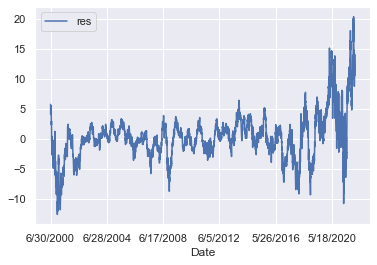

In [8]:
# Step 2: plot the corresponding residual
## Determine whether there is a clear pattern existing in our calculated residuals
roll_res.plot()

As can be seen here, there is a slightly increasing in absolute values in these residuals after the middle of the year 2016. However, the general residuals pattern is not clear, indicating the rolling regression is able to capture the majority of the relevant information in the data.

#### 3. Obtain the Variances (`var_t`) for Residuals (`ε(t)`)

Here we define a function `var_t` to obtain the variances for these computed residuals. Note that this function assumes a particular data structure (like pandas.DataFrame()) and order of columns in the data structure (like the input "roll_res" has only one column, which is the residuals from any model, the rolling regression model in this case.). If any of these rules violate, then simply change part of codes or the data to the one which can be call by the function directly.

In [9]:
# Step 1: Define the function 'var_t(...)' for obtaining our calculations 'var_t' for 'ε(t)'
def var_t(roll_res):
    """
    input: roll_res
    function: add an additional 'var_t' column to our original 'roll_res'
    (Note: no output in this case, just changing the input 'roll_res' by adding the 'var_t' column)
    """
    ## Initialize the column 'var_t' of the input 'roll_res' by setting each element of the 'var_t' column to NaN
    roll_res['var_t'] = float("nan")
    
    for i in range(len(roll_res)):
        ## Note that "ddof = 1" means we let the "n-1" in our denominator (using "n-1" for our degrees of freedom,
        ## where "n" is the sample size), obtaining an unbiased estimate of the population variance 
        roll_res.iloc[i,1] = np.var(roll_res.iloc[0:i, 0], ddof=1)

# Step 2: Call the 'var_t(...)' function in our case 
var_t(roll_res)

# Step 3: Drop the "NaN" in "roll_res"
roll_res.dropna(inplace = True)

## Take a look
roll_res

,res,var_t
Date,,
7/5/2000,4.081734,0.025577
7/6/2000,4.971266,0.825472
7/7/2000,5.519391,0.556046
7/10/2000,4.921728,0.454803
7/11/2000,4.112861,0.374261
...,...,...
12/27/2021,14.086926,13.706709
12/28/2021,12.147796,13.739389
12/29/2021,11.473650,13.762846


We need to obtain the `var_t` in this step since we need to design our trading strategies (i.e., generate our trading signals) later, which depend on `β_1(t)`, `ε(t)`, and `var_t`.

### 3. Method 2: Kalman Filter Regression

Now, we can move on to our main disccusion of the Kalman Filter Regression, which is the backbone of this project.

**State equation:** β(t) = F * β(t - 1) + w(t), where w(t) ~ N(0, Q)

**Measurement equation:** Y(t) = H * β(t) + v(t), where v(t) ~ N(0, R)

In this situation, we have:

**State equation:** β(t) = β(t - 1) + w(t), where w(t) ~ N(0, Q(t)) (Note: Q(t) = $\sigma_w^2$)

**Measurement equation:** spy(t) = djia(t) * β(t) + v(t), where v(t) ~ N(0, R(t)) (Note: R(t) =  $\sigma_v^2$)

Note that here we assumed the evolution of beta simply follows a random walk (i.e., F = 1) by our reference *Kalman filtering case study.pdf*.

#### 1. Perform the Ordinary Least Square Equation

We first need to initialize the ordinary least squares with the same `window = 252` as the rolling regression model case since we will compare these two model's performances in backtesting later. Then we can perform the ordinary least square regression model.

In [10]:
# Step 1: Obtain first 252 lines
base_df = prices.iloc[:126]

# Step 2: Perform the ordinary least squares equation
## We ignore the constant term, different than the rolling regression model, in this case
base_reg = ols('spy ~ djia - 1', data=base_df)
base_mod = base_reg.fit()

# Step 3: Take a look at the coefficient "β(t)"
base_mod.params 


djia    1.336767
dtype: float64

#### 2. Use the Kalman Filter 

Our goal is to estimate the optimal values of beta when we update our observations (in this case, "spy(t)" and "djia(t)"). The specific variables we currently focus on are `Q_t`, `R_t`, `w_t`, `beta_t`, `v_t`, `P_t_t-1`, `gamma`, and `kf_beta_t` (can be determined by `beta_t` in the specific formula derived on page 72 by *Kalman filtering case study.pdf*). The research of interest is the variable `kf_beta_t`. In order to derive `kf_beta_t`, we need all of the previous seven variables.

The Specific formula for each of these eight variables are:

(1) Q_t = $\sigma_w^2$, which is taking the variance of `beta_t` (*in code we used the best estimates of `beta_t`, which is our focus of interest `kf_beta_t` instead to obtain `Q_t`*);

(2) R_t = $\sigma_v^2$, which is the variance of our y: `spy(t)`;

(3) w_t ~ N(0, Q_t), which is a random normal variable drawn from N(0, Q_t);

(4) beta_t = beta_t-1 + w_t, assuming F = 1 (*in code we used the best estimates of `beta_t`, which is our focus of interest `kf_beta_t` instead to obtain `beta_t` as well*);

(5) v_t = spy_t - djia_t * beta_t, where v_t ~ N(0, R_t);

(6) P_t_t-1 = var(beta_t);

(7) $\gamma$ = P_t_t-1 / R_t, where $\gamma$ can also be called "SNR": the Signal-to-Noise Ratio;

(8) kf_beta_t = beta_t + (djia(t) * v_t) / ($djia(t)^2$ + $\gamma^2$).

Note that we need to initialize some variables before plugging the formulas defined above. First, we need to intialize variable `Q_t` by taking a uniform random variable from the range [0, 1]. Second, we should initialize variable `P_t_t-1` by using the same formula as the variable `w_t`, which is a random normal sample from N(0, Q_t). These intializations just show the state of the beginning process. And for simplicity, choosing such intializations is one option. In fact, the initializations will not be counted towards our final pairs trading strategy due to the first two "NaN" values for `var_t` (which are necessary in desiging our later pairs trading methods). So, initializations really do not matter

In [11]:
# Step 1: Get the copy from the orginal dataset "prices"
kf = prices.copy(deep = True)

In [12]:
# Step 2: Create new columns to include all needed variables
## First, intilializing all of them to "NaN"
kf['Q_t'] = float("nan")
kf['R_t'] = float("nan")
kf['w_t'] = float("nan")
kf['beta_t'] = float("nan")
kf['v_t'] = float("nan")
kf['P_t_t-1'] = float("nan")
kf['gamma'] = float("nan")
kf['kf_beta_t'] = float("nan")

In [13]:
# Step 3: Assign each variable's definition to each variable
def kalman_filter_beta(data, mod, window = 126):
    ## Start from the 253rd row
    ### Initialize a uniform random variable from the uniform distribution from [0, 1]
    data['Q_t'][window] = np.random.rand()
    
    ### Plug the definition for the "R_t" variable
    data['R_t'][window] = np.var(data['spy'][:window], ddof = 1)
    
    ### Use'Q_t' to obtain the distribution of "Q_t"
    data['w_t'][window] = np.random.normal(0, data['Q_t'][window])
    
    ### Use the "State equation" to obtain the "beta_t"
    data['beta_t'][window] = mod.params[0] + data['w_t'][window]
    
    ### Calculating the "v_t" from the corresponding equation 
    data['v_t'][window] = data['spy'][window] - data['beta_t'][window]*data['djia'][window]
    
    ### Let 'P_t_t-1' to be the variance of "beta_t" (initialize with the same as "w_t")
    data['P_t_t-1'][window] = np.random.normal(0, data['Q_t'][window])
    
    ### In this case, "gamma" = "P_t_t-1" / "R_t"
    data['gamma'][window] = data['P_t_t-1'][window] / data['R_t'][window]
    
    ### Plug in the formula for the Kalman Filter estimation for "beta_t"
    data['kf_beta_t'][window] = data['beta_t'][window] + (data['djia'][window] * data['v_t'][window]) /\
    (data['djia'][window] ** 2 + data['gamma'][window] ** (-1))
    
    ## Fill the constant term "b_0" in data for "window - 1" for "kf_beta_t" and "beta_t"
    data['kf_beta_t'][window - 1] = mod.params[0]
    data['beta_t'][window - 1] = mod.params[0]
    
    ## Fill in all of the remaining rows
    for i in range(window + 1, len(data)):
        ### Compute the remaining "Q_t" by assigning the variance of the "kf_beta_t" to it
        data['Q_t'][i] = np.var(data['kf_beta_t'][window - 1 : i], ddof = 1)
        
        ### Compute the remaining "R_t" by assigning the variance of the "spy_t" to it
        data['R_t'][i] = np.var(data['spy'][window - 1:i], ddof = 1)
        
        ### Compute the remaining "w_t" by taking a random variable from N(0, Q_t)
        data['w_t'][i] = np.random.normal(0, data['Q_t'][i])
        
        ### Compute the remaining "beta_t" by the formula "kf_beta_(t - 1) + w_t"
        data['beta_t'][i] = data['kf_beta_t'][i - 1] + data['w_t'][i]
        
        ### Compute the remaining "v_t" by the formula "spy_t - djia_t * beta_t"
        data['v_t'][i] = data['spy'][i] - data['djia'][i] * data['beta_t'][i]
        
        ### Compute the remaining "P_t_t-1" by assigning the variance of the variable "b_t" to it
        data['P_t_t-1'][i] = np.var(data['beta_t'][window - 1:i], ddof = 1)
        
        ### Compute the remaining "gamma" by the formula "P_t_t-1 / R_t", where "R_t" = "sigma_v^2"
        data['gamma'][i] = data['P_t_t-1'][i] / data['R_t'][i]
        
        ### Compute the remaining "kf_beta_t" by the last formula derived on page 72 for 
        ### "Kalman filtering case study.pdf"
        data['kf_beta_t'][i] = data['beta_t'][i] + (data['djia'][i] * data['v_t'][i]) / (data['djia'][i] ** 2 + \
                                                                                        data['gamma'][i] ** (-1))


The same as the function `process_data`, the above function `kalman_filter_beta` only applies a particular data structure (like pandas.DataFrame()) with a particular set of names of it (i.e., "spy", "djia", "Q_t", "R_t", "w_t", "beta_t", "v_t", "P_t_t-1", "gamma", and "kf_beta_t") as a given input. If any of these rules violate, then simply change part of codes or the data to the one which can be call by the function directly. 

In [14]:
# Step 4: Call the above "kalman_filter_beta(...)" function for our dataset "kf", and "mod" = "base_mod"
kalman_filter_beta(kf, base_mod)
## Take a look
kf

,spy,djia,Q_t,R_t,w_t,beta_t,v_t,P_t_t-1,gamma,kf_beta_t
Date,,,,,,,,,,
1/3/2000,145.4375,113.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/4/2000,139.7500,109.7656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/5/2000,140.0000,111.1875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/6/2000,137.7500,111.7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/7/2000,145.7500,115.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
12/27/2021,477.2600,362.9200,0.003767,7372.404629,-0.004344,1.292701,8.112862,0.003804,5.159613e-07,1.294124
12/28/2021,476.8700,363.9900,0.003772,7387.622834,0.000834,1.294958,5.518409,0.003808,5.154967e-07,1.295927
12/29/2021,477.4800,364.8400,0.003776,7402.786129,0.006458,1.302385,2.317845,0.003813,5.150562e-07,1.302793


#### 3. Residuals & Variances

In this section we compute the residuals and the corresponding variances of these residuals in the Kalman Filter regression.

In [15]:
# Step 1: Obtain residuals
kf_res = pd.DataFrame(kf['spy'] - kf['djia'] * kf['kf_beta_t'], columns=['res']).dropna()

# Step 2: Obtain variances for the residuals & Take a look
var_t(kf_res)

# Step 3: Drop "NaN" in "kf_res"
kf_res.dropna(inplace = True)

## Take a look
kf_res

,res,var_t
Date,,
7/5/2000,0.001416,6.883491
7/6/2000,0.002678,8.510795
7/7/2000,0.001593,7.361907
7/10/2000,-0.002321,6.281896
7/11/2000,-0.004162,5.433136
...,...,...
12/27/2021,7.596614,3.432287
12/28/2021,5.165611,3.442172
12/29/2021,2.169133,3.446364


<AxesSubplot: xlabel='Date'>

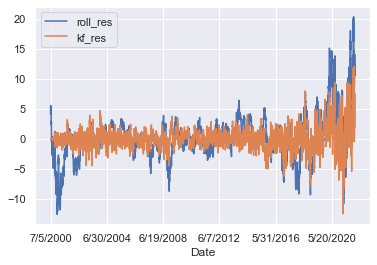

In [16]:
# Step 4: Comparison with "roll_res" and "kf_res"
## Generate a new dataset containing both residuals
### Make a copy or each model's residuals
roll_res_copy = roll_res.copy(deep = True)
kf_res_copy = kf_res.copy(deep = True)

### Rename the columns for each copy to combine later
roll_res_copy = roll_res_copy.rename(columns = {'res': 'roll_res', 'var_t': 'roll_var'})
kf_res_copy = kf_res_copy.rename(columns = {'res': 'kf_res', 'var_t': 'kf_var'})

### Concat residuals
res = pd.concat([roll_res_copy, kf_res_copy], axis = 1)


## Plot residuals
res[['roll_res', 'kf_res']].plot()

As can be seen, the residuals from these two models generally follow the approximated same ranges (except there is a big difference in residuals from the two models around the beginning of July, 2000), and show no clear patterns overall (even though both illustrating a slight trend of the increasing in the absolute values after 5.31/2016). This means that both models are able to capture the majority of the relevant information in the data.

### 4. Pairs Trading

We specify our pairs trading strategy here. Adopted from the paper, our trading strategies look like this:

(1) If $v_t$ >= k*$\sigma_t$, we long `beta_t` unit of Dow Jones Industrial ETF and short one unit of S&P 500 ETF ("-spy(t)" and "+$\beta_t$djia(t)");

(2) If $v_t$ <= - k*$\sigma_t$, we short `beta_t` unit of Dow Jones Industrial ETF and long one unit of S&P 500 ETF ("+spy(t)" and "-$\beta_t$djia(t)");

(3) Otherwise, we do nothing ([0, 0] positions in both `spy` and `djia`).

Also, $v_t$ = spy(t) - $\hat{\beta_t}$ * djia(t). And we take k = 0.5, 1, and 2 (the same as in our reference as well).

Note that in the first case (1), S&P 500 ETF is overbought (having a significantly higher price). So we buy `beta_t` unit of Dow Jones Industrial ETF and sell one unit of S&P 500 ETF. In the second case (2), Dow Jones Industrial ETF is overbought (having a significantly higher price). So we sell `beta_t` unit of Dow Jones Industrial ETF and buy one unit of S&P 500 ETF. In the third case (3), neither ETFs are overbought or oversold, so we do nothing.



#### 1. Define a class called `PairsTrading`

Different than previous sections, in this section we create a class to perform our pairs trading strategies, the comparison of each model's betas, and the final backtest settings.

Note that for the backtest strategy, we need to calculate the cumulative returns for our pairs trading strategy for each k. The basic rules for calculating the cumulative returns are as follows:

(1) Obtain the product of the trading signals and the daily returns for each ETFs;

(2) Sum the results from (1) up;

(3) Calculate the cumulative returns by the formula "np.cumprod(1 + (2))" from Python's numpy library.

In [17]:
class PairsTrading():
    # Intialization with object's attributes
    def __init__(self, res, betas, k_lst = [0.5, 1, 2]):
        self.res = res
        self.betas = betas
        self.k_lst = k_lst
        
    # Generate trading signals based on the pairs trading strategies spcified above   
    def generate_signals(self, mod):
        """
        input: mod: the specific regression model ("roll" or "kf"); 
        output: self.res: one of the class' attibutes containing both the residuals and signals for one either model
        function: generate new columns in "self.res" containing the trading signals for both spy and djia (Note: "+" 
        for buy and "-" for sell)
        """
        ## Make a copy of the class's attribute "self.res" to protect the original dataset
        residuals = self.res.copy(deep = True)
        
        ## Determine whether the input parameter "mod" is the rolling regression or the Kalman Filter model
        if mod == 'roll':
            ### Note that these indexes are based on the data structure of "self.res" and "self.betas"
            index_res = 0
            index_betas = 0
            index_var = 1
            
        elif mod == 'kf':
            index_res = 2
            index_betas = 1
            index_var = 3
        
        ### If either the case, we simply return the function
        else:
            return
            
        for k in self.k_lst:
            ## Define our trading threshold by the rules defined above
            thresholds = self.res.iloc[:, index_var] * k
            
            ## Initialize our trading signals for each ETFs to "NaN"
            residuals[f'spy_{k}'] = float("nan")
            residuals[f'djia_{k}'] = float("nan")
            
            ## Note that the length of "residuals" and "self.betas" are the same
            for i in range(len(residuals)):
                ## Check whether v_t >= k * sigma_t or not
                if self.res.iloc[i, index_res] >= thresholds[i]:
                    residuals[f'spy_{k}'][i] = -1
                    residuals[f'djia_{k}'][i] = self.betas.iloc[i, index_betas]
                    
                ## Check whether v_t <= -(k * sigma_t) or not
                elif self.res.iloc[i, index_res] <= -thresholds[i]:
                    residuals[f'spy_{k}'][i] = 1
                    residuals[f'djia_{k}'][i] = -self.betas.iloc[i, index_betas]
                    
                ## Otherwise, we enter zero positions in both cases
                else: 
                    residuals[f'spy_{k}'][i] = 0
                    residuals[f'djia_{k}'][i] = 0
                    
        ## Exclude all of the previous already-existed columns "roll_res", "roll_var", "kf_res", and "kf_var",
        ## starting by the index "4" till the end
        residuals = residuals.iloc[:, 4:]
                    
        return residuals
     
    # Plot the comparison graph for "betas" in different models
    def roll_vs_kf_params(self):
        """
        function: plot the parameters ("betas") for the rolling regressions and the Kalman Filter regression
        """
        self.betas.plot()
    
    # Perform our backtest case
    def backtest(self, data):
        """
        input: data: array containing 3 dfs, each containing b/s resulting from a k; ret: 1df containing daily ret
        ouput: cum_ret: 1 df containing cumret
        function: take "data", use its columns to compute the cumulative returns
        """
        ## Intialize our output
        cum_ret = pd.DataFrame()
        
        ## Calculate the cumulative returns
        for i, df in enumerate(data):
            ### Here, each df corresponding to a specific value of k from self.k_lst
            #### (1) from the rules above: multiply trading signals by daily returns for each ETFs
            df['spy_gain'] = df['spy_sign'] * df['spy_ret']
            df['djia_gain'] = df['djia_sign'] * df['djia_ret']
            
            #### (2) from the rules above: sum the results from (1) up
            df['dret'] = df['spy_gain'] + df['djia_gain']
            
            #### (3) from the rules above: plug in the formula for the cumulative returns
            df['cum_ret'] = np.cumprod(1 + df['dret'].values)
            
            ### Assigning "df['cum_ret']" to "cum_ret[f'{k[i]}']"
            cum_ret[f'{self.k_lst[i]}'] = df['cum_ret']
            
        return cum_ret 

As can be seen, most methods of the `PairsTrading` class only apply to the cases of rolling and Kalman Filter regressions, and only support certain types of data structures (like pandas.DataFrame()) and particular orders and/or names of columns in these data structures (i.e., variables `index_res`, `index_betas`, and `index_var` from the method `generate_signals` are fixed in this case for the assumed input data, and the names from the method `backtest` like "spy_ret", "spy_sign", "djia_ret", and "djia_sign"). If different data sturctures, dataset with a different order of columns, or the ones with different columns' names than assumed by the class are used, then either change the structures of the data or changing the order and/or names of (certain) columns to make it the same as the assumed one. Another possible way is to slightly change part of codes in this class to achieve the same goal as well.

#### 2. Generate the Trading Signals

In [18]:
# Step 1: Obtain "betas"
## Assign new variables "roll_beta" and "kf_beta" by dropping "NaN" values and
## renaming some columns the parameters ("betas" for "roll_mod.params.dropna()")
roll_beta = roll_mod.params.dropna().rename(columns = {'djia': 'roll_beta_t'})
kf_beta = kf[['kf_beta_t']].dropna()

## Merge the two new variables & Excluding the first two initializations
betas = pd.concat([roll_beta, kf_beta], axis = 1).iloc[2:, :]

## Take a look
betas

,roll_beta_t,kf_beta_t
Date,,
7/5/2000,1.338507,1.377367
7/6/2000,1.339553,1.386831
7/7/2000,1.340891,1.392785
7/10/2000,1.341991,1.388226
7/11/2000,1.343062,1.381450
...,...,...
12/27/2021,1.276240,1.294124
12/28/2021,1.276744,1.295927
12/29/2021,1.277290,1.302793


In [19]:
# Step 3: Call the "PairsTrading()" class
## Note that we just calculated "res" in the previous section
pairs_trading = PairsTrading(res, betas)

# Step 3: Generate the trading signals for each ETFs
roll_sign = pairs_trading.generate_signals("roll")
kf_sign = pairs_trading.generate_signals("kf")


In [20]:
# Step 4: Get the summary statistics for each type of trading signals
## "roll_sign" summary statistics
roll_sign.describe()

,spy_0.5,djia_0.5,spy_1,djia_1,spy_2,djia_2
count,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000
mean,-0.032723,0.038287,-0.014605,0.018351,-0.002958,0.003985
std,0.444228,0.515004,0.193193,0.227652,0.054312,0.073163
min,-1.000000,-1.360550,-1.000000,-1.221305,-1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.355520,1.000000,1.355520,0.000000,1.354663


In [21]:
## "kf_sign" summary statistics
kf_sign.describe()

,spy_0.5,djia_0.5,spy_1,djia_1,spy_2,djia_2
count,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000,5409.000000
mean,0.017378,-0.023414,0.014605,-0.018897,0.011832,-0.013913
std,0.797598,0.899465,0.601687,0.681204,0.318687,0.363495
min,-1.000000,-1.355292,-1.000000,-1.355292,-1.000000,-1.338031
25%,-1.000000,-1.089674,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.062776,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.363227,1.000000,1.358046,1.000000,1.294746


#### 3.  Comparison of Coefficients for each Model

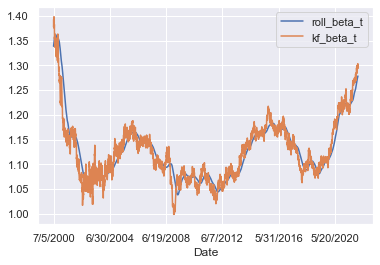

In [22]:
# Plot each model's paramters
pairs_trading.roll_vs_kf_params()

As can be seen, the betas (coefficients) from each model closely mimic each other (i.e., they produce closely similar betas' estimates).

#### 4: Backtest Results

In this sub-section, we backtested our pairs trading strategy by plotting the cumulative returns for each model.

In [23]:
# Step 1: find daily returns from prices
## Keep the orginial dataset intact by making a copy 
prices_copy = prices.copy(deep = True)

## Calculate daily returns for each ETFs by the percentage change formula
prices_copy['spy_ret'] = prices_copy['spy'].pct_change(1)
prices_copy['djia_ret'] = prices_copy['djia'].pct_change(1)

## Let the size of the dataset "prices_copy" be the same as the dataset "betas" or "res", "roll_sign", and "kf_sign",
## all of whose sizes are the same
prices_copy = prices_copy.loc[betas.index[0]:]

## Include only the daily returns by assigning a new variable "returns"
returns = prices_copy.iloc[:, 2:]

## Take a look at "returns"
returns

,spy_ret,djia_ret
Date,,
7/5/2000,-0.018036,-0.009142
7/6/2000,0.007779,0.000893
7/7/2000,0.016081,0.011745
7/10/2000,-0.001688,0.001617
7/11/2000,0.002114,0.007042
...,...,...
12/27/2021,0.014152,0.009907
12/28/2021,-0.000817,0.002948
12/29/2021,0.001279,0.002335


In [24]:
# Step 2: Create a function "data_merge(..)" to transform avaliable dataset useful for backtest to merger them into a 
# single one which can be used directly to the method "backtest" of the class "PairsTrading" defined previously
def data_merge(trade_signal, daily_returns, k_lst = [0.5, 1, 2]):
    ## Intialize a list "results" to contain each "pandas.DataFrame" data structure (having a total of three in this
    ## case)
    results = []
    
    ## For each k value in "k_lst", we generate a particualr "pandas.DataFrame" data structure
    for i in range(len(k_lst)):
        ### We obtain the index for the data "trade_signal" to begin our information extraction
        ### Typically, since the length of "trade_signal" is twice the one of "k_lst",
        ### we multiply the index for "k_lst" by 2 to get "trade_signal"'s index
        index = i * 2
        
        ### We need to obtain two columns in each case (i.e., the trading signals for "spy" and "djia")
        df1 = trade_signal.rename(columns = {f'spy_{k_lst[i]}': 'spy_sign', \
                                             f'djia_{k_lst[i]}': 'djia_sign'}).iloc[:, index:index + 2]
        
        ### Merge the two dataset, "df1" and "daily_returns", to one
        df2 = pd.concat([df1, daily_returns], axis = 1)
        
        ### Add the merged one to the existing targeted list "results" defined in the first place
        results.append(df2)
        
    return results


Note that as the same rules as before, the function `data_merge` assumes particular input data (i.e., the data structure "pandas.DataFrame()", the particular order of columns, and the certain names of columns). So the methods for any parts violating these rules are the same: simply change (part of) codes or the data to the one which can be call by the function directly. 

In [25]:
# Step 3: Call the function "data_merge(...)" for our data processing 
## The rolling regression model
roll = data_merge(roll_sign, returns)

### Take a look at "df"
roll

[            spy_sign  djia_sign   spy_ret  djia_ret
 Date                                               
 7/5/2000        -1.0   1.338507 -0.018036 -0.009142
 7/6/2000        -1.0   1.339553  0.007779  0.000893
 7/7/2000        -1.0   1.340891  0.016081  0.011745
 7/10/2000       -1.0   1.341991 -0.001688  0.001617
 7/11/2000       -1.0   1.343062  0.002114  0.007042
 ...              ...        ...       ...       ...
 12/27/2021      -1.0   1.276240  0.014152  0.009907
 12/28/2021      -1.0   1.276744 -0.000817  0.002948
 12/29/2021      -1.0   1.277290  0.001279  0.002335
 12/30/2021      -1.0   1.277814 -0.002765 -0.002111
 12/31/2021      -1.0   1.278304 -0.002520 -0.002060
 
 [5409 rows x 4 columns],
             spy_sign  djia_sign   spy_ret  djia_ret
 Date                                               
 7/5/2000        -1.0   1.338507 -0.018036 -0.009142
 7/6/2000        -1.0   1.339553  0.007779  0.000893
 7/7/2000        -1.0   1.340891  0.016081  0.011745
 7/10/2000       -

In [26]:
## The Kalman Filter regression model
kf = data_merge(kf_sign, returns)

### Take a look at "df"
kf

[            spy_sign  djia_sign   spy_ret  djia_ret
 Date                                               
 7/5/2000         0.0   0.000000 -0.018036 -0.009142
 7/6/2000         0.0   0.000000  0.007779  0.000893
 7/7/2000         0.0   0.000000  0.016081  0.011745
 7/10/2000        0.0   0.000000 -0.001688  0.001617
 7/11/2000        0.0   0.000000  0.002114  0.007042
 ...              ...        ...       ...       ...
 12/27/2021      -1.0   1.294124  0.014152  0.009907
 12/28/2021      -1.0   1.295927 -0.000817  0.002948
 12/29/2021      -1.0   1.302793  0.001279  0.002335
 12/30/2021      -1.0   1.300965 -0.002765 -0.002111
 12/31/2021      -1.0   1.302327 -0.002520 -0.002060
 
 [5409 rows x 4 columns],
             spy_sign  djia_sign   spy_ret  djia_ret
 Date                                               
 7/5/2000         0.0   0.000000 -0.018036 -0.009142
 7/6/2000         0.0   0.000000  0.007779  0.000893
 7/7/2000         0.0   0.000000  0.016081  0.011745
 7/10/2000        

As can be roughly seen above, as k increases, more and more postions get empty (zeros) for both ETFs. This is reasonable since the entry threshold gets stricter (i.e., k is used in the formula for constructing the entry thresholds: +-k*$\sigma_t$): only if the residuals after each model exceeds a wider range composed by larger thresholds can we enter the buying and selling signals.

<AxesSubplot: xlabel='Date'>

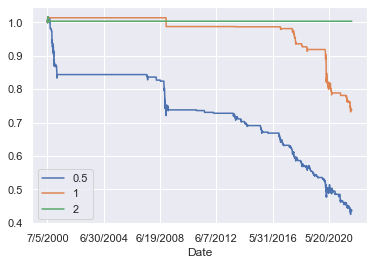

In [27]:
# Step 4: Call the method "backtest(...)" from the "PairsTrading()" class
backtest_roll = pairs_trading.backtest(roll)
backtest_kf = pairs_trading.backtest(kf)

# Step 5: Plot the results
## Plot the rolling regression
backtest_roll.plot()

<AxesSubplot: xlabel='Date'>

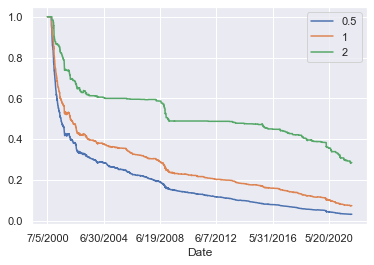

In [28]:
## Plot the Kalman Filter regression
backtest_kf.plot()

#### 5. Comparison of Rolling Regression with Kalman Filter:
We reached the conclusion that both the rolling and the Kalman Filter regression did not provide good cumulative returns overall. Actually, the best cumulative return is slightly over "1", which is the case investors entered zerons position for `k = 2` in the rolling regression situation. This is probably due to the situation in which the we did not accurately predict the that the low prices mean the greater increase in daily returns. In other words, the ETFs with lower prices did not turn out to perform well in the later, indicating that the ETFs were not oversold (undervalued) in the real case. This is also partly due to the increasing performance (i.e., increasing prices) for both S&P 500 ETF and the Dow Jones Induatrial ETF, indicating these two ETFs are actually doing pretty well in their recent decades, making the pairs trading strategy extremely difficult since it is a market neutral method. A a result, more research needs to be done in the future to investigate more models (i.e., supprot vector machines, reinforcement learing, copulas, ...) to try out the pairs trading strategy.

(Note: in this research, we were unable to find the outperforming pairs trading strategies after different trials of combinations of hyperparameters' tuning and the subset dataset extraction for S&P 500 ETFs and Dow Jones Industrial ETFs, all of which produced a decreasing cumulative returns steadily, sad.)

<AxesSubplot: xlabel='Date'>

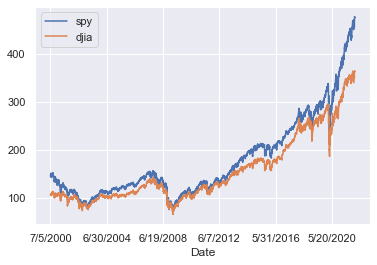

In [29]:
# Plot the closing prices' trend during the pairs trading periods
prices_copy[['spy', 'djia']].plot()

As can be shown, the closing prices for S&P 500 ETF and Dow Jones Industrial ETF are in a strongly increasing trend, making market-neutral methods like the pairs trading strategy result in decreasing cumulative returns overall, let alone outperforming the market.